 Path integral biased simulations
 --------------------------------

In [ ]:
from shlex import split as split_cmd
from subprocess import Popen
from xml.etree import ElementTree as et

from jax import numpy as np
from jax import jit, vmap
from matplotlib import pyplot as plt

from ipi.utils.messages import verbosity
from ipi.utils.scripting import InteractiveSimulation

import pysages
from pysages import CVRestraints, Grid
from pysages.approxfun.core import cartesian_product, compute_mesh
from pysages.backends import SamplingContext
from pysages.colvars import Distance
from pysages.colvars.coordinates import distance
from pysages.colvars.core import FourPointCV
from pysages.methods import Metadynamics, SpectralABF
from pysages.utils import last

 ## Setting up the simulations

In [ ]:
input_md = "data/input-md.xml"


def generate_simulation(input=input_md, setup_verbosity="quiet"):
    with open(input, "r") as f:
        input_xml = f.read()
        verbosity.level = setup_verbosity
        simulation = InteractiveSimulation(input_xml)
    return simulation

In [ ]:
class DriversLauncher:
    def __init__(self, address, mode, n_drivers=1, working_path="data/"):
        self.n_drivers = n_drivers
        self.path = working_path
        self.cmd = split_cmd(f"i-pi-driver -u -a {address} -m {mode}")

    def __call__(self):
        return [Popen(self.cmd, cwd=self.path) for _ in range(self.n_drivers)]

 Collective variable implementation

In [ ]:
def rational_decay_6_12(r, r_0=1, d_0=0):
    rho = (r - d_0) / r_0
    return 1 / (1 + rho**6)


class CoordinationNumberDifference(FourPointCV):
    def __init__(self, indices, switching_function=rational_decay_6_12):
        super().__init__(indices)
        self.s = switching_function

    @property
    def function(self):
        return jit(
            lambda p1, p2, p3, p4: coordination_number(p1, p2, self.s)
            - coordination_number(p3, p4, self.s)
        )


def coordination_number(p1, p2, switching_function=rational_decay_6_12):
    d = vmap(distance, in_axes=(None, 0))(p1, p2)
    return np.sum(vmap(switching_function)(d))

 Unit conversions: i-PI uses atomic units

In [ ]:
a_0 = 0.052917721  # Bohr radius in nm
Ha_in_eV = 27.2114079527
Ha_in_kJ_per_mol = 2625.499638
K_in_Ha = 1 / 315774.66

switching_function = lambda r: rational_decay_6_12(r, r_0=0.14 / a_0)

 Target collective variables

In [ ]:
cvs = (
    Distance([0, 1]),
    CoordinationNumberDifference(
        [[0], list(range(2, 7)), [1], list(range(2, 7))], switching_function
    ),
)

 Sampling method

In [ ]:
d_OO_min = 0.21 / a_0  # 2.1 Å in atomic units
d_OO_max = 0.31 / a_0  # 3.1 Å in atomic units
k_wall = (250 / Ha_in_kJ_per_mol, 0)
height_0 = 4 / Ha_in_kJ_per_mol
sigma = (0.005 / a_0, 0.05)

grid = Grid((d_OO_min, -1), (d_OO_max, 1), (32, 32))
restraints = CVRestraints((d_OO_min, -1), (d_OO_max, 1), k_wall, k_wall)
# method = SpectralABF(cvs, grid, restraints=restraints)
method = Metadynamics(
    cvs, height=height_0, sigma=sigma, stride=10, ngaussians=2000, deltaT=2700, kB=K_in_Ha
)

 Biased classical MD simulation

In [ ]:
launch_drivers_md = DriversLauncher("zundel", "zundel", n_drivers=1)
sampling_context_md = SamplingContext(method, generate_simulation, launch_drivers=launch_drivers_md)

r_md = pysages.run(sampling_context_md, 5000)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so" +++


PLUMED: PLUMED is starting
PLUMED: Version: 2.11.0-dev (git: 0e3e3eb2b) compiled on Sep  2 2025 at 17:23:27
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/pzubieta/.mamba/envs/pysages-dev/lib/plumed
PLUMED: LibraryPath: /home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so
PLUMED: For installed feature, see /home/pzubieta/.mamba/envs/pysages-dev/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: i-pi
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 7
PLUMED: File suffix: 
PLUMED: FILE: data/plumed-md.dat
PLUMED: Action DISTANCE
PLUMED:   with label doo
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED: Action DISTANCES
PLUMED:   with label co1
PLUMED: Action DISTANCE
PLUMED:   with label co1
PLUMED:   between atoms 1 3
PLUMED:   be

 Biased PIMD simulation

In [ ]:
launch_drivers_pimd = DriversLauncher("zundel_pi", "zundel", n_drivers=4)
sampling_context_pimd = SamplingContext(
    method,
    generate_simulation,
    launch_drivers=launch_drivers_pimd,
    context_args=dict(input="data/input-pimd.xml"),
)

r_pimd = pysages.run(sampling_context_pimd, 5000)

PLUMED: PLUMED is starting
PLUMED: Version: 2.11.0-dev (git: 0e3e3eb2b) compiled on Sep  2 2025 at 17:23:27
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/pzubieta/.mamba/envs/pysages-dev/lib/plumed
PLUMED: LibraryPath: /home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so
PLUMED: For installed feature, see /home/pzubieta/.mamba/envs/pysages-dev/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: i-pi
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 7
PLUMED: File suffix: 
PLUMED: FILE: data/plumed-pimd.dat
PLUMED: Action DISTANCE
PLUMED:   with label doo
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED: Action DISTANCES
PLUMED:   with label co1
PLUMED: Action DISTANCE
PLUMED:   with label co1
PLUMED:   between atoms 1 3
PLUMED:   

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/pzubieta/.mamba/envs/pysages-dev/lib/libplumedKernel.so" +++


 @simulation.run: Average timings at MD step       0. t/step: 1.05939e-02
 @simulation.run: Average timings at MD step     100. t/step: 1.01516e-02
 @simulation.run: Average timings at MD step     200. t/step: 9.86855e-03
 @simulation.run: Average timings at MD step     300. t/step: 9.81947e-03
 @simulation.run: Average timings at MD step     400. t/step: 1.07350e-02
 @simulation.run: Average timings at MD step     500. t/step: 1.03400e-02
 @simulation.run: Average timings at MD step     600. t/step: 1.01219e-02
 @simulation.run: Average timings at MD step     700. t/step: 1.10826e-02
 @simulation.run: Average timings at MD step     800. t/step: 1.09767e-02
 @simulation.run: Average timings at MD step     900. t/step: 1.01522e-02
 @simulation.run: Average timings at MD step    1000. t/step: 1.01079e-02
 @simulation.run: Average timings at MD step    1100. t/step: 1.08792e-02
 @simulation.run: Average timings at MD step    1200. t/step: 1.11788e-02
 @simulation.run: Average timings at M

 ### Analysis

In [ ]:
result_md = pysages.analyze(r_md)
result_pimd = pysages.analyze(r_pimd)

T = float(last(et.parse(input_md).iter("temperature")).text.strip())


def metad_fes(result, xi, T, deltaT, shape=-1, shift=True):
    alpha = (T + deltaT) / deltaT
    A = -alpha * result["metapotential"](xi)
    A = A - A.min() if shift else A
    A = A.reshape(shape).T
    return A


plot_grid = Grid((d_OO_min, -1), (d_OO_max, 1), (128, 128))
xi = compute_mesh(plot_grid)

A_md = Ha_in_eV * metad_fes(result_md, xi, T, method.deltaT, plot_grid.shape)
A_pimd = Ha_in_eV * metad_fes(result_pimd, xi, T, method.deltaT, plot_grid.shape)

 ### Free energy profiles

In [ ]:
extent = [10 * d_OO_min * a_0, 10 * d_OO_max * a_0, -1, 1]

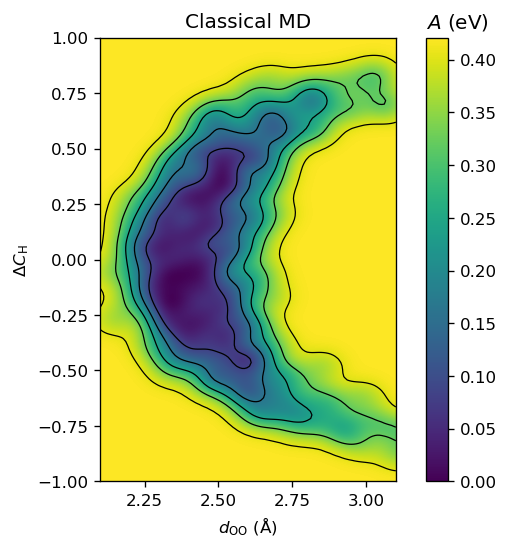

In [ ]:
fig, ax = plt.subplots(dpi=120)
im = ax.imshow(A_md, interpolation="bicubic", origin="lower", extent=extent, aspect=3 / 4)
ax.contour(A_md, levels=5, linewidths=0.75, colors="k", extent=extent)
ax.set_title("Classical MD")
ax.set_xlabel(r"$d_\mathrm{OO}$ (Å)")
ax.set_ylabel(r"$\Delta C_\mathrm{H}$")
cbar = plt.colorbar(im)
cbar.ax.set_title("$A$ (eV)", loc="left")
plt.show()

Text(0.0, 1.0, '$A$ (eV)')

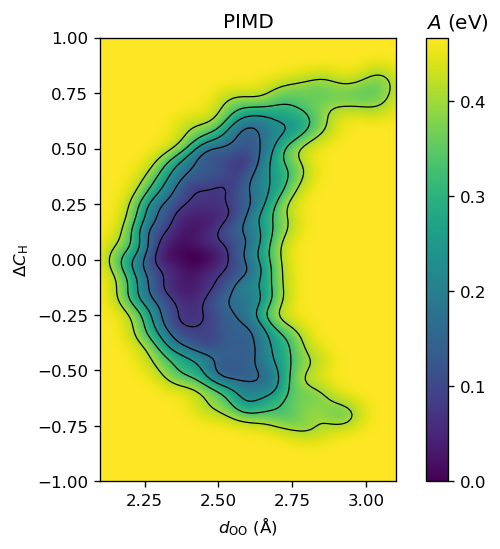

In [ ]:
fig, ax = plt.subplots(dpi=120)
im = ax.imshow(A_pimd, interpolation="bicubic", origin="lower", extent=extent, aspect=3 / 4)
ax.contour(A_pimd, levels=5, linewidths=0.75, colors="k", extent=extent)
ax.set_title("PIMD")
ax.set_xlabel(r"$d_\mathrm{OO}$ (Å)")
ax.set_ylabel(r"$\Delta C_\mathrm{H}$")
cbar = plt.colorbar(im)
cbar.ax.set_title("$A$ (eV)", loc="left")

 ### Assessing quantum nuclear effects

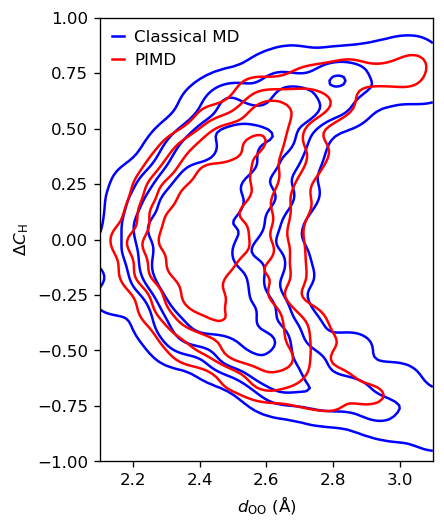

In [ ]:
fig, ax = plt.subplots(dpi=120)
levels = np.linspace(0, 0.5, 6)
ax.contour(A_md, colors="b", levels=levels, extent=extent)
ax.contour(A_pimd, colors="r", levels=levels, extent=extent)
ax.set_box_aspect(4 / 3)
ax.set_ylabel(r"$\Delta C_\mathrm{H}$")
ax.set_xlabel(r"$d_\mathrm{OO}$ (Å)")
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="b", label="Classical MD"),
        plt.Line2D([0], [0], color="r", label="PIMD"),
    ],
    frameon=False,
    borderpad=0.2,
    handlelength=0.75,
    handletextpad=0.6,
    loc="upper left",
)
plt.show()

 The lowering of the barrier is more apparent from 1D slices at differnt O-O distances

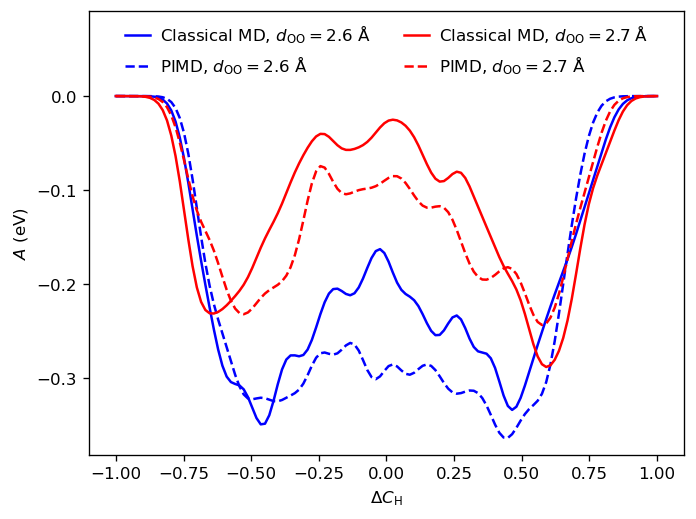

In [ ]:
xi_delta = np.linspace(-1, 1, 128)

fig, ax = plt.subplots(dpi=120)

xi_slice = cartesian_product(np.array([2.6]) / (10 * a_0), xi_delta)
ax.plot(
    xi_delta,
    Ha_in_eV * metad_fes(result_md, xi_slice, T, method.deltaT, shift=False),
    "b",
    label=r"Classical MD, $d_\mathrm{OO}=2.6 $ Å",
)
ax.plot(
    xi_delta,
    Ha_in_eV * metad_fes(result_pimd, xi_slice, T, method.deltaT, shift=False),
    "b--",
    label=r"PIMD, $d_\mathrm{OO}=2.6 $ Å",
)

xi_slice = cartesian_product(np.array([2.7]) / (10 * a_0), xi_delta)
ax.plot(
    xi_delta,
    Ha_in_eV * metad_fes(result_md, xi_slice, T, method.deltaT, shift=False),
    "r",
    label=r"Classical MD, $d_\mathrm{OO}=2.7 $ Å",
)
ax.plot(
    xi_delta,
    Ha_in_eV * metad_fes(result_pimd, xi_slice, T, method.deltaT, shift=False),
    "r--",
    label=r"PIMD, $d_\mathrm{OO}=2.7 $ Å",
)

ax.set_ylim(top=0.09)
ax.legend(
    ncols=2, loc="upper center", frameon=False, borderpad=0.2, handlelength=1.5, handletextpad=0.6
)
ax.set_ylabel(r"$A$ (eV)")
ax.set_xlabel(r"$\Delta C_\mathrm{H}$")
plt.show()